<a href="https://colab.research.google.com/github/ayami-n/Flax_text_prediction/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Flax_text_prediction

/content/drive/MyDrive/Flax_text_prediction


# Import libs

In [ ]:
%%capture
!pip install git+https://github.com/huggingface/transformers.git
!pip install flax
!pip install git+https://github.com/deepmind/optax.git

In [5]:
import jax
from jax import random  # to create random values for initalizing a model (Flax requires)
import jax.numpy as jnp

# Flax for building model
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
    
from flax import linen as nn
from flax.training import train_state, checkpoints
from flax.core.frozen_dict import freeze, unfreeze

# Optax for optimizor 
import optax

# Transformers
!pip install transformers
from transformers import FlaxAutoModelForSequenceClassification, RobertaTokenizer, RobertaConfig # as we use Roberta model
from transformers.modeling_flax_utils import FlaxPreTrainedModel  # FlaxMLPModule is still stateless

# others
import pandas as pd
from tqdm import tqdm
from typing import Callable, Any
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import numpy as np

     |████████████████████████████████| 202 kB 25.1 MB/s 
     |████████████████████████████████| 217 kB 68.1 MB/s 
     |████████████████████████████████| 145 kB 74.2 MB/s 
     |████████████████████████████████| 596 kB 63.3 MB/s 
     |████████████████████████████████| 9.1 MB 63.9 MB/s 
     |████████████████████████████████| 51 kB 6.4 MB/s 
     |████████████████████████████████| 72 kB 709 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 24.6 MB/s 
     |████████████████████████████████| 6.6 MB 54.4 MB/s 
     |████████████████████████████████| 101 kB 15.4 MB/s 


# Config

In [6]:
model_checkpoint = 'siebert/sentiment-roberta-large-english' # https://huggingface.co/docs/transformers/model_doc/roberta#roberta
seed = 0  # for building our model

tokenizer = RobertaTokenizer.from_pretrained(model_checkpoint)  # this tokenizer converts numeric from string: the values are different if you select different model_checkpoint

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/687 [00:00<?, ?B/s]

# Tokenaization

In [ ]:
'''
https://stackoverflow.com/questions/65246703/how-does-max-length-padding-and-truncation-arguments-work-in-huggingface-bertt
adding [CLS] token at the beginning of the sentence, and [SEP] token at the end of sentence.
[CLS] I love you [SEP] is expected by BERT. 
tokenizer gives [CLS] and [SEP] usually
'''

In [7]:
df = pd.read_csv("./kaggle/train.csv")  # import train datasets
new_label = {"discourse_effectiveness": {"Ineffective": 0, "Adequate": 1, "Effective": 2}}  # to replace 
df = df.replace(new_label) 

In [ ]:
max = 0
max_str = "Who is Max?"
words_list = []
for itr, val in enumerate(df['discourse_text'].to_numpy()):
  words = val.split()
  words_list.append(len(words))

  if len(words) > max:
    max = len(words)
    max_str = val

print(pd.Series(list(filter(lambda x: (x <= 256), words_list))).count(), len(words_list))    

36566 36765


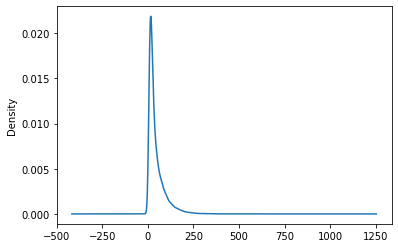

In [ ]:
'''
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.plot.kde.html
'''
pd.Series(words_list).plot.kde()  # most words are less than 250

In [8]:
train_df, val_df = train_test_split(df, test_size=0.05, random_state=seed)  # spliting datasets 95% train and 5% val

max_len = 256  # input text should be the same length (most words <= 256)

dummy = tokenizer(train_df['discourse_text'].to_numpy()[:1][0], # [:1][0] -> makes str
                  max_length=max_len, truncation=True, 
                  padding='max_length', 
                  return_tensors='jax') # add_special_tokens=True is default: truncation=True is cutting off longer sentences (longer than max_length)

dummy_input_ids, dummy_attention_mask = dummy['input_ids'], dummy['attention_mask']  # jax: the values (text) are converted by the tokenizer, the values (attention-mask) are converted by the tokenizer

In [ ]:
tokenizer.convert_ids_to_tokens(dummy_input_ids.squeeze())[:30]  # checking the converted id's

['<s>',
 'In',
 'Ġconclusion',
 ',',
 'Ġthe',
 'ĠElectoral',
 'ĠCollege',
 'Ġshould',
 'Ġbe',
 'Ġkept',
 '.',
 'ĠIt',
 'Ġinduces',
 'Ġthe',
 'Ġcandidates',
 '.',
 'ĠIt',
 'Ġrestores',
 'Ġsome',
 'Ġof',
 'Ġthe',
 'Ġweight',
 'Ġthat',
 'Ġthe',
 'Ġlarge',
 'Ġstates',
 'Ġloses',
 '.',
 'ĠIt',
 'Ġavoids']

# Loading Data

In [20]:
class token_loader(Dataset): # Dataset is abstract class -> must have __init__, __getitem__, and __len__
  def __init__(self, this_df, max_length):   
    self.this_df = this_df  # store the train or val datasets
    self.this_max_length = int(max_length)  # for the tokenaizer 
    self.lebel = this_df['discourse_effectiveness'].to_numpy()  # return as np
    self.text = this_df['discourse_text'].to_numpy()  # store the values as numpy 
    self.length = len(this_df)   

  def __len__(self):  # to return size of datasets
    return self.length  # assume path contains path of the all images 

  def __getitem__(self, index):  # text -> tokenaizer -> ids, attention-masks, labels

    # todo: if the text len is over 256, where should we feed it into the tokenaizer? 
    
    token = tokenizer(self.text[index], 
                      max_length=self.this_max_length, 
                      truncation=True, padding='max_length', 
                      return_tensors='np') # add_special_tokens=True is default: truncation=True is cutting off longer sentences (longer than max_length)
      
    return token['input_ids'], token['attention_mask'], self.lebel[index]  # it should be Numpy: not jax array -> errors

In [21]:
def custom_collate_fn(batch):  # converting tensor -> array as flax needs numpy or jax array
    transposed_data = list(zip(*batch))
    
    ids = np.stack(transposed_data[0])
    masks = np.stack(transposed_data[1])

    labels = np.array(transposed_data[2])

    return ids, masks, labels

In [22]:
train_data = token_loader(train_df, max_len)
train = DataLoader(dataset=train_data, batch_size=8, num_workers=2, shuffle=True, collate_fn=custom_collate_fn)
print(next(iter(train)))

(array([[[    0, 25354,  6645, ...,     1,     1,     1]],

       [[    0,   970,    32, ...,     1,     1,     1]],

       [[    0,   243,    16, ...,     1,     1,     1]],

       ...,

       [[    0, 39043,   687, ...,     1,     1,     1]],

       [[    0, 21518,  1219, ...,     1,     1,     1]],

       [[    0, 17276,   912, ...,     1,     1,     1]]]), array([[[1, 1, 1, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 0, 0, 0]],

       ...,

       [[1, 1, 1, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 0, 0, 0]]]), array([0, 1, 2, 1, 2, 0, 2, 1]))


In [23]:
val_data = token_loader(val_df, max_len)
val = DataLoader(dataset=val_data, collate_fn=custom_collate_fn)
print(next(iter(val)))

(array([[[    0,  3972,  1642,     6,     5,  1219,    16,    14,     5,
          1298,  1984,    18,   458,     9,     5,  7169,  1564, 12259,
          2456,  4735, 23984,    39,   458,     9,     5,  1406,   900,
             4,  1437,     2,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1

# Create a model

In [9]:
# the model size is 1.32G
pretrained_roberta = FlaxAutoModelForSequenceClassification.from_pretrained(model_checkpoint, seed=seed)  

Downloading:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

In [80]:
class MyNLP(nn.Module):
    roberta: nn.Module

    @nn.compact
    def __call__(self, input_ids, attention_mask, train=True):  # https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/ 
        out = self.roberta(input_ids, attention_mask, output_hidden_states=True)  # extract all hidden layers: but we need the last (attention) layer, in particular, [CLS]  
        cls_embedding = out.hidden_states[0][:,0,:] # (1, 1024): [:,0,:] -> first : is all sentences, 0 is [CLS], last : is all hidden unit outputs

        #### Transfer Learning: name should be alpabet orders for the summary ####
        out = nn.Dense(features=512, name="A")(input_ids)  
        out = nn.Dense(features=256, name="B")(out)

        out = nn.Dropout(0.1, deterministic=True, name='C')(out)  # deteministic=true: no mask and apply the rate

        out = nn.Dense(features=64, name="D")(out)
        out = nn.Dense(features=3, name="E")(out)
        # out = nn.softmax(out)

        return out

# Define Loss

In [68]:
def cross_entropy_loss(logits, labels, num_classes):
  labels_onehot = jax.nn.one_hot(labels, num_classes=num_classes)
  return optax.softmax_cross_entropy(logits=logits, labels=labels_onehot).mean()   # return example: 0.96834594

# Compute Metrics

In [69]:
def compute_metrics(*, logits, labels):
  num_classes = len(logits[-1])
  loss = cross_entropy_loss(logits, labels, num_classes)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)

  metrics = {
      'loss': loss,
      'accuracy': accuracy,
  }
  return metrics

## Define the Training State

In [93]:
def create_train_state(seed, pretrained_model, dummy_input_ids, dummy_attention_mask, lr):  

  ### initialize the model ###
  init_rng = jax.random.PRNGKey(seed)

  model = MyNLP(pretrained_model)  # create a model
  print(model.tabulate(init_rng, dummy_input_ids, dummy_attention_mask))  # display the summary
  variables = model.init(init_rng, dummy_input_ids, dummy_attention_mask)  # store [A-E] variables

  # inserting the pretrained parameters into the correct place on the new parameter structure as names will matter 
  #### add randomly initialized params with pretrained params ####
  # variables = unfreeze(variables)  # unfreeze: Makes a mutable copy of a FrozenDict mutable by transforming it into (nested) dict
  # variables['params']['RoberTa'] = pretrained_roberta.params  # adding roberta params to the randomly initialized params
  # variables = freeze(variables)  # freeze: An immutable variant of the Python dict.

  #### Falx updates parmas while the training phase ####
  lr = lr # 2e-5 = 0.00002
  opt = optax.adam(learning_rate=lr, b1=0.9, b2=0.999)

  state = train_state.TrainState.create(
      apply_fn=model.apply,
      params=variables['params'],
      tx=opt
      )
  
  return state

# Define the Training/Evaluation Steps

In [71]:
def compute_loss(state, params, input_ids, attention_mask, labels):
    logits = state.apply_fn({'params': params}, input_ids, attention_mask)  # example return: DeviceArray([[0.15097128, 0.6676195 , 0.18140921]], dtype=float32)
    loss = cross_entropy_loss(logits=logits, labels=labels, num_classes=len(logits[-1]))  # example return 0.40403685
    return loss, logits

In [72]:
@jax.jit
def train_step(state, input_ids, attention_mask, labels):  # softmax

  # do the forward pass and get the loss and gradients
  grad_function = jax.value_and_grad(compute_loss, has_aux=True, allow_int=True)  # def loss_function(params) is wrapped by Jax to calculate loss and gradient
  (loss, logits), grad = grad_function(state, state.params, input_ids, attention_mask, labels)

  # this function calls tx.update() followed by a call to optax.apply_updates() to update params and opt_state
  new_state = state.apply_gradients(grads=grad)  # update params with Adam  
  # metrics = compute_metrics(logits=logits, labels=labels) 
  
  return new_state #, metrics

In [29]:
@jax.jit
def eval_step(state, input_ids, attention_mask, labels):  # argmax
    logits = state.apply_fn({'params': state.params}, input_ids, attention_mask, labels)
    return compute_metrics(logits=logits, labels=labels)  # return loss and accuracy

# Main Functions

In [62]:
def train_one_epoch(state, dataloader):
    """Train for 1 epoch on the training set."""
    batch_metrics = []
    for itr, (train_input_ids, train_attention_mask, train_label) in enumerate(train):        
        state, metrics = train_step(state, train_input_ids, train_attention_mask, train_label)
        batch_metrics.append(metrics)

    batch_metrics_np = jax.device_get(batch_metrics)  
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
        for k in batch_metrics_np[0]
    }

    return state, epoch_metrics_np

In [ ]:
state = create_train_state(seed, pretrained_roberta, dummy_input_ids, dummy_attention_mask, 2e-5)

In [ ]:
state.params

In [96]:
logits = state.apply_fn({'params': state.params}, dummy_input_ids, dummy_attention_mask)
logits

DeviceArray([[5726.1973, 3089.8079, 6497.5693]], dtype=float32)

In [ ]:
batch_metrics = []
for itr, (train_input_ids, train_attention_mask, train_label) in enumerate(val):        
    state, metrics = train_step(state, train_input_ids, train_attention_mask, train_label)
    batch_metrics.append(metrics)

    batch_metrics_np = jax.device_get(batch_metrics)  
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
        for k in batch_metrics_np[0]
    }

    if itr == 2: 
      break

In [53]:
def evaluate_model(state, val):
    """Evaluate on the validation set."""
    for itr, (val_input_ids, val_attention_mask, val_label) in enumerate(val):   
      metrics = eval_step(state, val_input_ids, val_attention_mask, val_label)
      metrics = jax.device_get(metrics) 
      metrics = jax.tree_map(lambda x: x.item(), metrics)  
    return metrics

In [54]:
def main(seed, pretrained_roberta, dummy_input_ids, dummy_attention_mask):
  num_epochs = 2
  
  training_loss = []
  training_accuracy = []
  testing_loss = []
  testing_accuracy = []

  state = create_train_state(seed, pretrained_roberta, dummy_input_ids, dummy_attention_mask, 2e-5)

  for epoch in range(num_epochs):
      new_state, new_metrics = train_one_epoch(state, train)
      training_loss.append(new_metrics['loss'])
      training_accuracy.append(new_metrics['accuracy'])
      print(f"Train epoch: {epoch}, loss: {new_metrics['loss']}, accuracy: {new_metrics['accuracy'] * 100}")

      # if epoch % 2 == 0:
      #   test_metrics = evaluate_model(train_state, val)
      #   testing_loss.append(test_metrics['loss'])
      #   testing_accuracy.append(test_metrics['accuracy'])
      #   print(f"Test epoch: {epoch}, loss: {test_metrics['loss']}, accuracy: {test_metrics['accuracy'] * 100}")

In [55]:
main(seed, pretrained_roberta, dummy_input_ids, dummy_attention_mask)

TypeError: ignored